# GPC vs. LM(Dirichlet)+GP

test the different concepts on toy data and compare

In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

### Toy data

we use the same toy data as presented in the GPC tutorial

In [2]:
def gen_data(num_data, seed = 2019):
    torch.random.manual_seed(seed)

    x = torch.randn(num_data,1)
    y = torch.randn(num_data,1)

    u = torch.rand(1)
    data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = torch.round(latent_fn).long().squeeze()
    return torch.cat((x,y),dim=1), z, data_fn

In [3]:
train_x, train_y, genfn = gen_data(500)

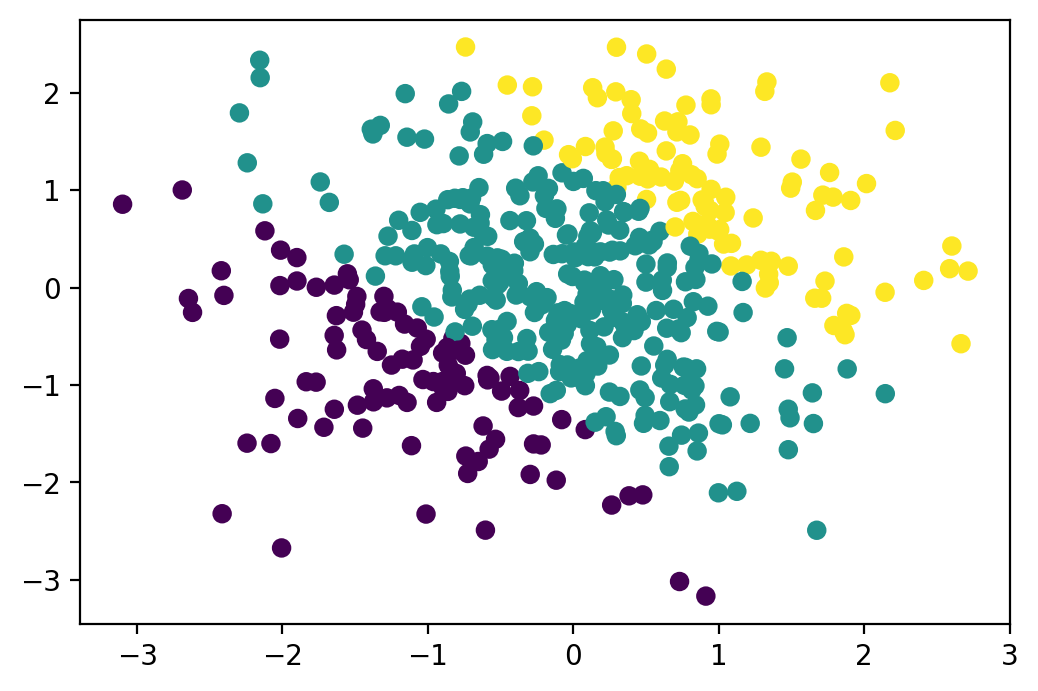

In [4]:
fig = plt.figure(dpi=200)
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y);

In [5]:
test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1)

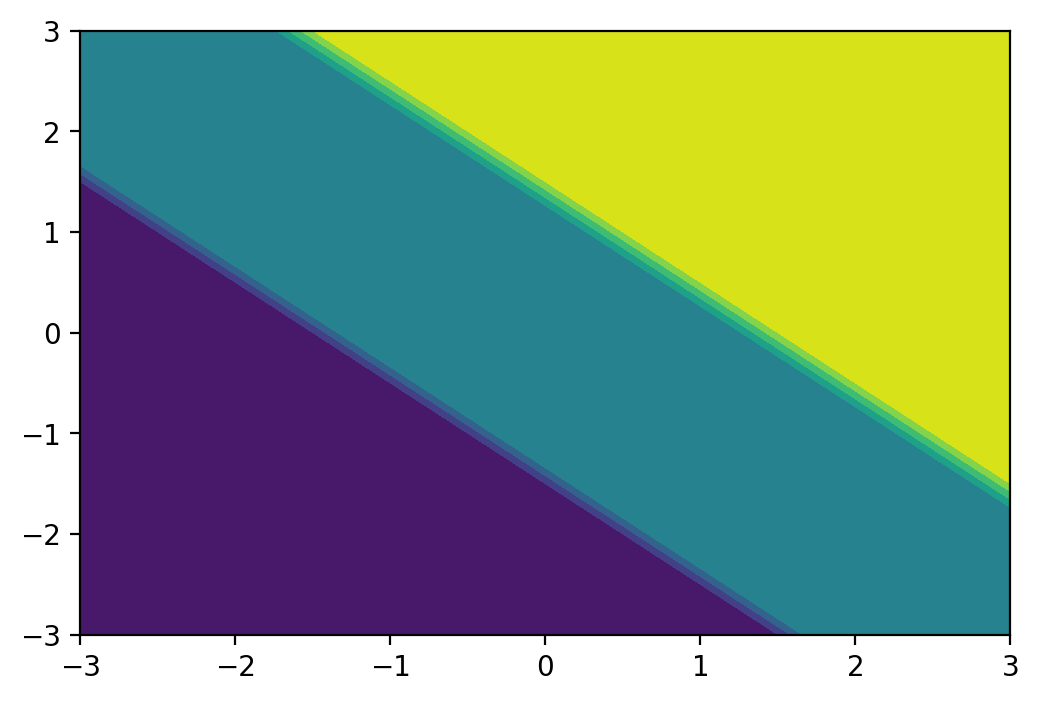

In [6]:
fig = plt.figure(dpi=200)
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy());

## Define and train models

In [7]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

NUM_CLASSES = 3

### GPC model

In [8]:
# define GPC like in tutorial
# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [9]:
# this is for running the notebook in our testing framework
training_iter = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
    loss.backward()
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 6.431   lengthscale: 0.693   noise: 0.693
Iter 6/50 - Loss: 5.934   lengthscale: 0.939   noise: 0.475
Iter 11/50 - Loss: 5.749   lengthscale: 1.056   noise: 0.322
Iter 16/50 - Loss: 5.591   lengthscale: 1.014   noise: 0.220
Iter 21/50 - Loss: 5.484   lengthscale: 0.906   noise: 0.153
Iter 26/50 - Loss: 5.391   lengthscale: 0.803   noise: 0.109
Iter 31/50 - Loss: 5.320   lengthscale: 0.722   noise: 0.080
Iter 36/50 - Loss: 5.282   lengthscale: 0.669   noise: 0.060
Iter 41/50 - Loss: 5.258   lengthscale: 0.632   noise: 0.047
Iter 46/50 - Loss: 5.237   lengthscale: 0.614   noise: 0.037


In [10]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc

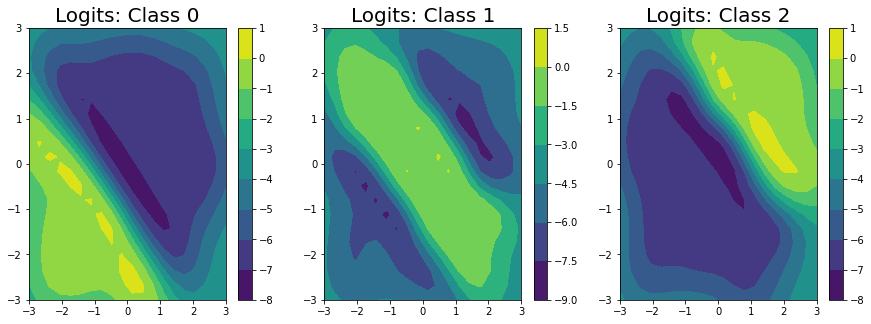

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

In [12]:
pred_samples = test_dist.sample(torch.Size((1000,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

/Users/mariushobbhahn/opt/anaconda3/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/mariushobbhahn/opt/anaconda3/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


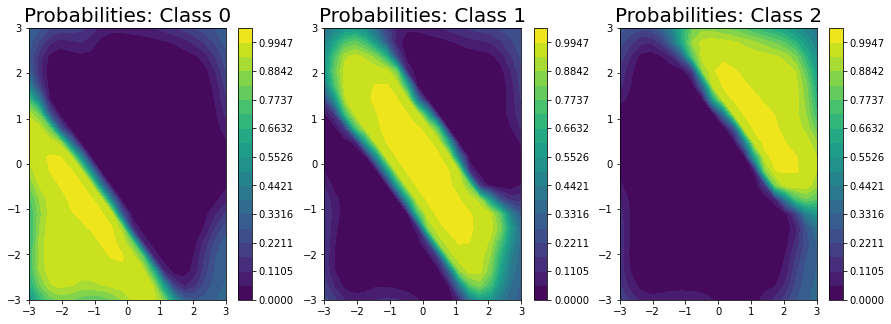

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

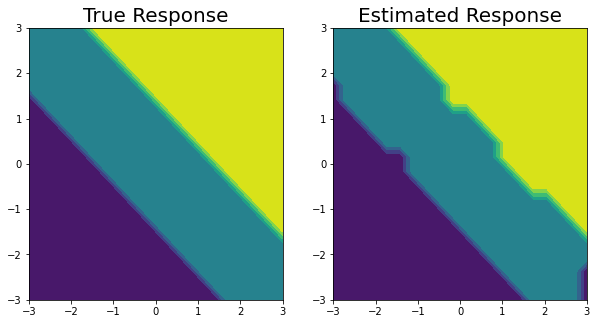

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)

### LM(Dirichlet)+GP model

This approach is based on the GPyTorch multitask regression tutorial: https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

Note: I wasn't able to build a solution based on the GPyTorch batch shape tutorial (not sure why): https://docs.gpytorch.ai/en/stable/examples/08_Advanced_Usage/Simple_Batch_Mode_GP_Regression.html

In [15]:
# apply the Laplace Bridge
def Dirichlet_bridge_mu(alpha):
    alpha = np.array(alpha, dtype='int')
    k = len(alpha)
    C = 1/k * np.sum(np.log(alpha))
    return(np.log(alpha) - C)

def Dirichlet_bridge_mu_batch(alpha):
    K = alpha.size(-1)
    return(torch.log(alpha) - 1/K * torch.sum(torch.log(alpha), dim=1).view(-1, 1))

def Dirichlet_bridge_Sigma_diag(alpha):
    K = len(alpha)
    Sigma_diag = 1/alpha * (1 + 2/K) + 1/K**2 * np.sum(1/alpha)            
    return(Sigma_diag)

def Dirichlet_bridge_Sigma_diag_batch(alpha):
    K = alpha.size(-1)
    Sigma_diag = 1/alpha * (1 + 2/K) + 1/K**2 * torch.sum(1/alpha, dim=0)            
    return(Sigma_diag)

def Dirichlet_bridge_alpha(mu, Sigma):
    K = len(mu)
    Sigma_diag = np.diag(Sigma)
    sum_m_exp = np.sum(np.exp(-mu))
    return(1/Sigma_diag * (1 - 2/K + np.exp(mu)/K**2 * sum_m_exp))

In [108]:
# transform data
train_y_one_hot = torch.nn.functional.one_hot(train_y, num_classes=NUM_CLASSES) 
a_eps = 0.00001
alphas = train_y_one_hot + a_eps

train_mu_LM = Dirichlet_bridge_mu_batch(alphas)
train_var_LM = Dirichlet_bridge_Sigma_diag_batch(alphas)
print(train_mu_LM.size(), train_var_LM.size(), train_x.size())

torch.Size([500, 3]) torch.Size([500, 3]) torch.Size([500, 2])


## Use multitask output

In [109]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_classes
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_classes, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=NUM_CLASSES)
model = MultitaskGPModel(train_x, train_mu_LM, likelihood, num_classes=NUM_CLASSES)

In [110]:
training_iterations = 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_mu_LM)
    loss.backward()
#    print(model.covar_module.data_covar_module.lengthscale)
    if i % 5 == 0:
        print('Iter %d/%d - Loss: %.3f; lengthscale: %.3f; noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.data_covar_module.lengthscale.mean().item(),
            model.likelihood.noise.mean().item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 3.822; lengthscale: 0.693; noise: 0.693
Iter 6/50 - Loss: 2.922; lengthscale: 0.789; noise: 0.967
Iter 11/50 - Loss: 2.565; lengthscale: 0.673; noise: 1.254
Iter 16/50 - Loss: 2.399; lengthscale: 0.600; noise: 1.503
Iter 21/50 - Loss: 2.307; lengthscale: 0.580; noise: 1.684
Iter 26/50 - Loss: 2.250; lengthscale: 0.581; noise: 1.796
Iter 31/50 - Loss: 2.210; lengthscale: 0.574; noise: 1.847
Iter 36/50 - Loss: 2.180; lengthscale: 0.553; noise: 1.849
Iter 41/50 - Loss: 2.155; lengthscale: 0.537; noise: 1.812
Iter 46/50 - Loss: 2.133; lengthscale: 0.529; noise: 1.745


In [111]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x)

    pred_means = test_dist.loc

In [112]:
print(test_x.size())
print(test_dist)
pred_means = pred_means.view(400,3)
pred_means = torch.swapaxes(pred_means, 0, 1)
print(pred_means.size())

torch.Size([400, 2])
MultitaskMultivariateNormal(loc: torch.Size([1200]))
torch.Size([3, 400])


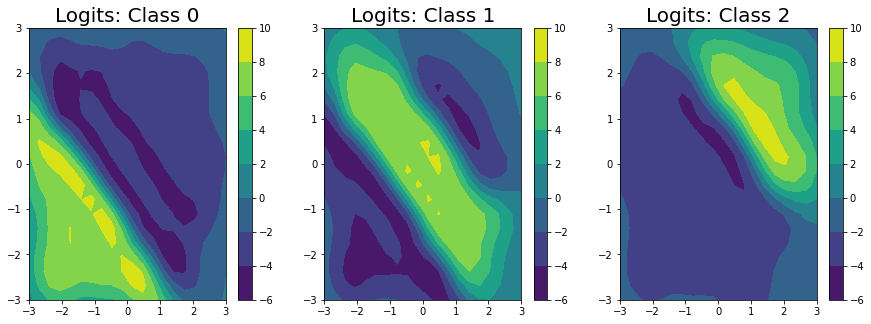

In [113]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

In [114]:
pred_samples = test_dist.sample(torch.Size((1000,))).exp().view(1000, 400, 3).swapaxes(1,2)
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

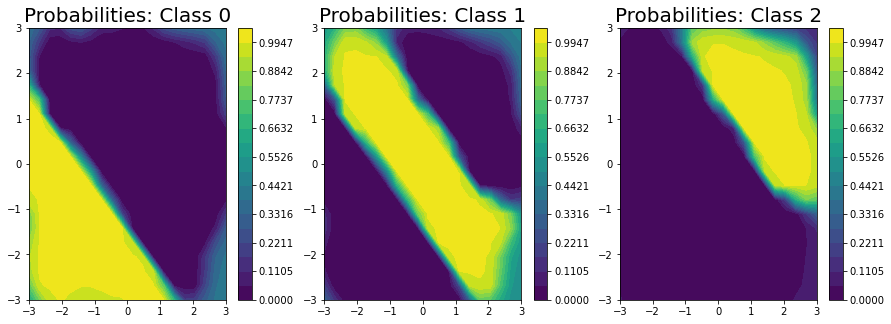

In [115]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

levels = np.linspace(0, 1.05, 20)
for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

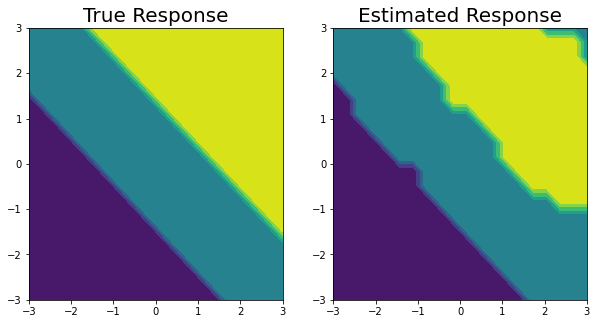

In [116]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((20,20)))
ax[1].set_title('Estimated Response', fontsize=20)

# solution based on batched GP

In [89]:
# TODO: https://docs.gpytorch.ai/en/stable/examples/08_Advanced_Usage/Simple_Batch_Mode_GP_Regression.html?highlight=batch_shape#Setting-up-the-model

# Would be nice for the heteroskedastic noise model